In [1]:
#Settings
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
import pathlib

#乱数の固定
import os
import random
os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#ベースモデル
BASE_MODEL="VGG16"

#バッチサイズと画像サイズの設定
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

#読み込むデータのディレクトリを指定（このフォルダの下に分類ごとにフォルダ分けして保存してあること）
data_root = pathlib.Path("./Image/Fruits")
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [3]:
#Load Data as dataset
# Train:Validation:Test = 7:1.5:1.5

ValidateionSplitRate=0.3

train_dataset=image_dataset_from_directory(
    data_root , labels='inferred', label_mode='categorical',#intの場合、モデルにはloss='sparse_categorical_crossentropy'を設定する。別のcategoricalはダメ。
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMG_SIZE,
     shuffle=True, seed=SEED, validation_split=ValidateionSplitRate, subset="training",#これがトレーニング用であることを示す
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)
validation_dataset=image_dataset_from_directory(
    data_root , labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMG_SIZE,
     shuffle=True, seed=SEED, validation_split=ValidateionSplitRate, subset="validation",#これがValidation用であることを示す
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)
class_names = train_dataset.class_names
print("class_names=",class_names)

Found 759 files belonging to 5 classes.
Using 532 files for training.
Found 759 files belonging to 5 classes.
Using 227 files for validation.
class_names= ['apple_braeburn', 'apple_golden_delicious', 'apple_topaz', 'peach', 'pear']


2021-11-10 02:34:40.138153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:65:00.0, compute capability: 8.6


2021-11-10 02:34:40.370223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


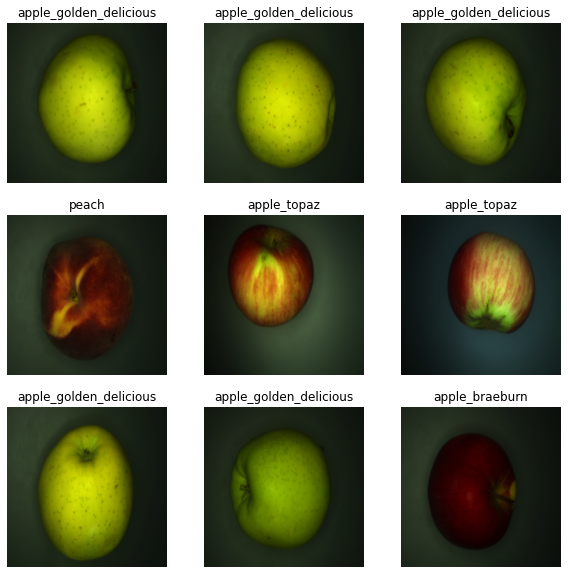

In [4]:
plt.figure(figsize=(10, 10))
for element in train_dataset.as_numpy_iterator():#データセットはバッチサイズを1単位としてラベルと画像が入っているので、.take(1)とすると1つ目のバッチを取り出すことになる
    images=element[0]
    labels=element[1]
    for i in range(9):#バッチにはバッチサイズ分の数の画像とラベルが入っている。最初の9枚分を見せている
        #print(labels)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        class_id=np.argmax(labels, axis=1)
        plt.title(class_names[class_id[i]])
        plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 4


パフォーマンスのためにデータセットを構成する

バッファ付きプリフェッチを使用して、I/O のブロッキングなしでディスクから画像を読み込みます。この手法の詳細についてはデータパフォーマンスガイドをご覧ください。

In [7]:
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

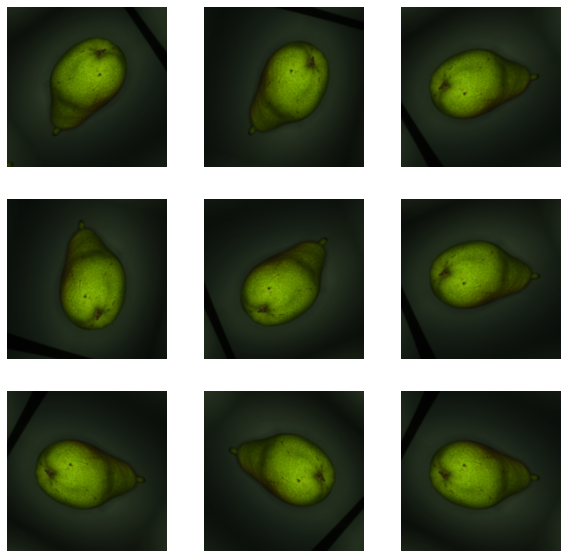

In [9]:
#Check
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [11]:
#Model setting
preprocess_input = tf.keras.applications.vgg16.preprocess_input
#inputs = tf.keras.Input(shape=(IMG_SHAPE))#入力Tensor
#inputs=data_augmentation(inputs)
#inputs = preprocess_input(inputs)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                   include_top=False,
                                   weights='imagenet',
                                   classes = len(class_names))
base_model.trainable=False

In [12]:
last_layer=base_model.layers[-1]#-1で末尾を取り出せる
#print(last_layer.output_shape)
last_layer_outputshape=last_layer.output_shape
dense_unit_to_set=last_layer_outputshape[-1]#-1で末尾を取り出せる
#print("Set this unit=", dense_unit_to_set)

x=base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(dense_unit_to_set,activation='relu')(x)#入力パラメータ数(ベースの一番最後の行？）と隠れ層

prediction_layer = tf.keras.layers.Dense(len(class_names),activation="softmax")#SpareでもCategoricalでも、Softmaxにしたら確率出るようだ（合計１）    
x = prediction_layer(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
    

In [13]:
#パラメータの設定
base_learning_rate = 0.0001
batch_size= BATCH_SIZE
momentum_usage=0.99
initial_epochs = 50

sgd=tf.keras.optimizers.SGD(learning_rate=base_learning_rate,momentum=momentum_usage)
model.compile(optimizer=sgd,loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
print("Trainable vals=",len(model.trainable_variables) )
print(model.summary())

Trainable vals= 4
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56,

In [14]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/backend.py:4846: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2021-11-10 02:36:02.924726: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


 2/17 [==>...........................] - ETA: 2s - loss: 3.1153 - accuracy: 0.1250 

2021-11-10 02:36:04.724135: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


17/17 [==============================] - 6s 165ms/step - loss: 2.5119 - accuracy: 0.2086 - val_loss: 2.0379 - val_accuracy: 0.3434
Epoch 2/50
17/17 [==============================] - 3s 151ms/step - loss: 1.5864 - accuracy: 0.4248 - val_loss: 0.9773 - val_accuracy: 0.6465
Epoch 3/50
17/17 [==============================] - 3s 149ms/step - loss: 0.9601 - accuracy: 0.6203 - val_loss: 0.5278 - val_accuracy: 0.7980
Epoch 4/50
17/17 [==============================] - 3s 147ms/step - loss: 0.7037 - accuracy: 0.7312 - val_loss: 0.3374 - val_accuracy: 0.8788
Epoch 5/50
17/17 [==============================] - 3s 148ms/step - loss: 0.5131 - accuracy: 0.8195 - val_loss: 0.4691 - val_accuracy: 0.8081
Epoch 6/50
17/17 [==============================] - 3s 148ms/step - loss: 0.4058 - accuracy: 0.8383 - val_loss: 0.3601 - val_accuracy: 0.8283
Epoch 7/50
17/17 [==============================] - 3s 156ms/step - loss: 0.3773 - accuracy: 0.8421 - val_loss: 0.2060 - val_accuracy: 0.9293
Epoch 8/50
17/17 

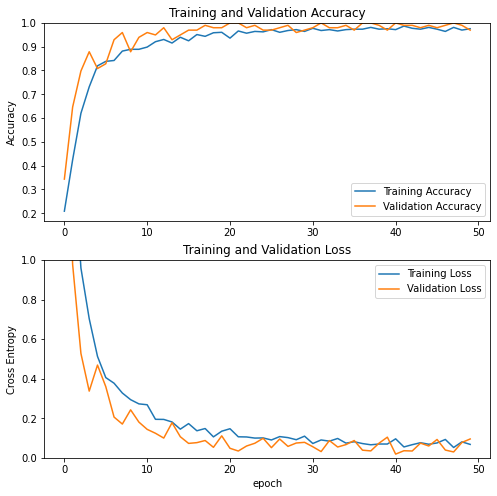

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

3 : 94.48156356811523


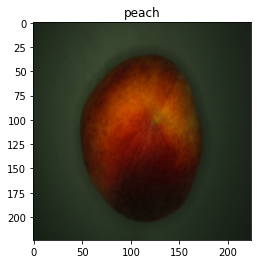

0 : 77.46474146842957


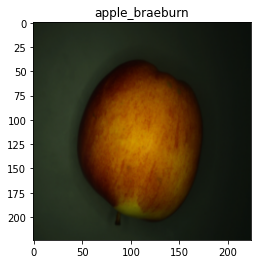

2 : 91.2530779838562


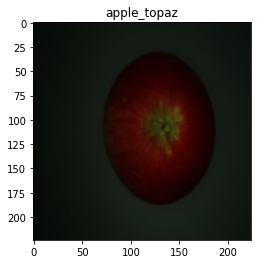

0 : 60.110193490982056


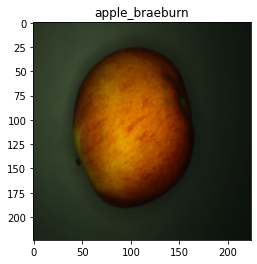

1 : 99.94895458221436


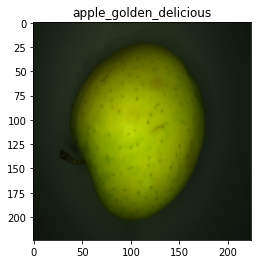

2 : 99.78972673416138
2 : 99.99411106109619
3 : 99.91281628608704
4 : 99.99996423721313
0 : 98.98161888122559
4 : 100.0
4 : 99.99960660934448
0 : 99.99357461929321
4 : 100.0
0 : 96.3069200515747
4 : 100.0
1 : 99.99700784683228
0 : 99.98657703399658
3 : 99.67195391654968
4 : 99.9974012374878
2 : 99.99699592590332
4 : 99.99971389770508
1 : 99.98866319656372
1 : 99.81942772865295
3 : 98.75409007072449
3 : 97.1899926662445
3 : 99.99998807907104
2 : 99.8717188835144
3 : 99.4097352027893
4 : 99.9981164932251
2 : 99.99964237213135
1 : 87.19125390052795
0 : 95.84622383117676
3 : 99.24037456512451
4 : 100.0
4 : 99.99935626983643
2 : 99.99998807907104
1 : 99.98772144317627
2 : 99.75318908691406
1 : 99.98676776885986
3 : 99.99258518218994
4 : 99.99998807907104
1 : 99.41720366477966
2 : 99.998939037323
1 : 99.58082437515259
1 : 99.76699948310852
0 : 67.02718138694763
1 : 99.96601343154907
1 : 99.9707043170929
4 : 99.99972581863403
1 : 99.94934797286987
1 : 98.36408495903015
4 : 99.99291896820068
0

In [16]:
#テストデータセットから画像とラベルを取得
all_labels = np.ndarray(0)
all_preds = np.ndarray(0)

num_set=tf.data.experimental.cardinality(test_dataset)

iterator = iter(test_dataset)
for p in range(0, num_set):
    dset = iterator.get_next()
    #print(p, ":",dset[1])
    image_batch=dset[0]
    label_batch=dset[1]
    
    for i in range(0, len(image_batch)):#.as_numpy_iterator():#データセットはバッチサイズを1単位としてラベルと画像が入っているので、.take(1)とすると1つ目のバッチを取り出すことになる
        #print(image_batch[i].shape)
        
        preds=model(tf.reshape(image_batch[i],[-1,IMG_SHAPE[0],IMG_SHAPE[1],IMG_SHAPE[2]]))

        pred_class_id=np.argmax(preds)
        gt_class_id=np.argmax(label_batch[i])
        
        confi_arr=preds.numpy()[0]
        #print(confi_arr, pred_class_id)
        confi=confi_arr[pred_class_id]
        print(pred_class_id,":",confi*100)
        
        all_preds=np.append(all_preds,pred_class_id)
        all_labels=np.append(all_labels,gt_class_id)
        
        if(p==0 and i<5):
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            class_id=np.argmax(label_batch[i])
            plt.title(class_names[pred_class_id])
            plt.pause(0.001)

In [17]:
test_accuracy = tf.keras.metrics.Accuracy()
test_accuracy(all_preds, all_labels)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 98.438%


In [18]:
model.save("FruitsSorter2CategoryNoInputTensor"+BASE_MODEL+".tf")

2021-11-10 02:39:05.383801: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: FruitsSorter2CategoryNoInputTensorVGG16.tf/assets


In [ ]:
#RESET KERNEL to release memory on GPU!